In [25]:
# Do not change this cell

import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchinfo import summary

import matplotlib.pyplot as plt
from timeit import default_timer as timer

import numpy as np

random_seed = 1
torch.manual_seed(random_seed)
np.random.seed(random_seed)

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

trainset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=ToTensor()
)
validationset = torchvision.datasets.FashionMNIST(
    root='./data', train=True, download=True, transform=ToTensor()
)
testset = torchvision.datasets.FashionMNIST(
    root='./data', train=False, download=True, transform=ToTensor()
)
classes = trainset.classes

valid_size = 0.2
train_length = len(trainset)
indices = list(range(len(trainset)))
split = int(np.floor(valid_size * train_length))

np.random.shuffle(indices)

train_idx=indices[split:]
valid_idx=indices[:split]
train_sampler=SubsetRandomSampler(train_idx)
validation_sampler=SubsetRandomSampler(valid_idx)

batch_size = 256
train_loader = DataLoader(trainset, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(validationset, batch_size=batch_size, sampler=validation_sampler)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False)

print(f"Length of train data loader: {len(train_loader)} batches of {batch_size}")
print(f"Length of validation data loader: {len(valid_loader)} batches of {batch_size}")
print(f"Length of test data loader: {len(test_loader)} batches of {batch_size}")

# Check out what is inside the training data loader
train_features_batch, train_label_batch = next(iter(train_loader))
print(train_features_batch.shape, train_label_batch.shape)

Length of train data loader: 188 batches of 256
Length of validation data loader: 47 batches of 256
Length of test data loader: 40 batches of 256
torch.Size([256, 1, 28, 28]) torch.Size([256])


In [26]:
# Do not change this cell
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

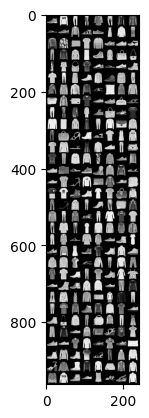

In [27]:
# Do not change this cell
dataiter = iter(test_loader)
images, labels = next(dataiter)
# Show images
imshow(torchvision.utils.make_grid(images))

In [ ]:
import torch.nn.functional as F

# Define the CNN model
class ConvModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(ConvModel, self).__init__()
        
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, output_size)
        
        
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x) 
        
        return x


In [ ]:
def train_step(model, train_loader, loss_fn, optimizer, reg_param, device):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for batch in train_loader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = loss_fn(outputs, targets)
        
        l2_reg = sum(torch.norm(param, p=2) ** 2 for param in model.parameters())
        loss += reg_param * l2_reg
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    
    avg_loss = train_loss / len(train_loader)
    accuracy = 100.0 * correct / total
    
    return avg_loss, accuracy

In [ ]:
def evaluation_step(model, data_loader, loss_fn, reg_param, device):
    model.eval()  
    eval_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():  
        for batch in data_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            
            loss = loss_fn(outputs, targets)
        
            l2_reg = sum(torch.norm(param, p=2) ** 2 for param in model.parameters())
            loss += reg_param * l2_reg
            
            eval_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    avg_loss = eval_loss / len(data_loader)
    accuracy = 100.0 * correct / total
    
    return avg_loss, accuracy


In [ ]:
def train_conv_model(train_loader, valid_loader, test_loader, random_seed):
    # Make device
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    else:
        if torch.backends.mps.is_available():
            device = "mps"
    
    torch.manual_seed(random_seed)  # do not change this

    
    input_size = 1  
    output_size = len(classes)  
    model = ConvModel(input_size, output_size).to(device)
    
    loss_fn = nn.CrossEntropyLoss()  
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
    reg_param = 0.0001  
    
    
    num_epochs = 20 
    train_losses, train_accuracies = [], []
    valid_losses, valid_accuracies = [], []
    test_losses, test_accuracies = [], []
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")

        
        train_loss, train_accuracy = train_step(model, train_loader, loss_fn, optimizer, reg_param, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        
        valid_loss, valid_accuracy = evaluation_step(model, valid_loader, loss_fn, reg_param, device)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)
        
        
        test_loss, test_accuracy = evaluation_step(model, test_loader, loss_fn, reg_param, device)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        
        
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.2f}%")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    
    return model, train_losses, train_accuracies, valid_losses, valid_accuracies, test_losses, test_accuracies


In [32]:
def plot_accuracy_performance(train_accuracies, valid_accuracies, test_accuracies):
    epochs = range(1, len(train_accuracies) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_accuracies, label="Train Accuracy", marker="o")
    plt.plot(epochs, valid_accuracies, label="Validation Accuracy", marker="s")
    plt.plot(epochs, test_accuracies, label="Test Accuracy", marker="x")

    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training, Validation, and Test Accuracy Over Epochs")
    plt.legend()
    plt.grid(True)

    plt.show()


In [33]:
def plot_loss_performance(train_losses, valid_losses, test_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_losses, label="Train Loss", marker="o", color="blue")
    plt.plot(epochs, valid_losses, label="Validation Loss", marker="s", color="green")
    plt.plot(epochs, test_losses, label="Test Loss", marker="x", color="red")

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training, Validation, and Test Loss Over Epochs")
    plt.legend()
    plt.grid(True)

    plt.show()

In [34]:
# Do not change this cell
random_seed = 1
model, train_losses, train_accuracies, valid_losses, valid_accuracies, test_losses, test_accuracies\
= train_conv_model(train_loader, valid_loader, test_loader, random_seed)

Epoch 1/20
Train Loss: 0.5529, Train Accuracy: 81.68%
Validation Loss: 0.3823, Validation Accuracy: 87.26%
Test Loss: 0.4023, Test Accuracy: 86.20%
Epoch 2/20
Train Loss: 0.3455, Train Accuracy: 89.20%
Validation Loss: 0.3145, Validation Accuracy: 89.96%
Test Loss: 0.3393, Test Accuracy: 88.85%
Epoch 3/20
Train Loss: 0.3058, Train Accuracy: 90.63%
Validation Loss: 0.3070, Validation Accuracy: 90.02%
Test Loss: 0.3262, Test Accuracy: 89.63%
Epoch 4/20
Train Loss: 0.2755, Train Accuracy: 91.68%
Validation Loss: 0.2912, Validation Accuracy: 91.22%
Test Loss: 0.3189, Test Accuracy: 90.18%
Epoch 5/20
Train Loss: 0.2562, Train Accuracy: 92.47%
Validation Loss: 0.2691, Validation Accuracy: 92.07%
Test Loss: 0.2879, Test Accuracy: 91.68%
Epoch 6/20
Train Loss: 0.2322, Train Accuracy: 93.38%
Validation Loss: 0.2690, Validation Accuracy: 92.03%
Test Loss: 0.2916, Test Accuracy: 91.55%
Epoch 7/20
Train Loss: 0.2203, Train Accuracy: 93.87%
Validation Loss: 0.2766, Validation Accuracy: 91.77%
Test 

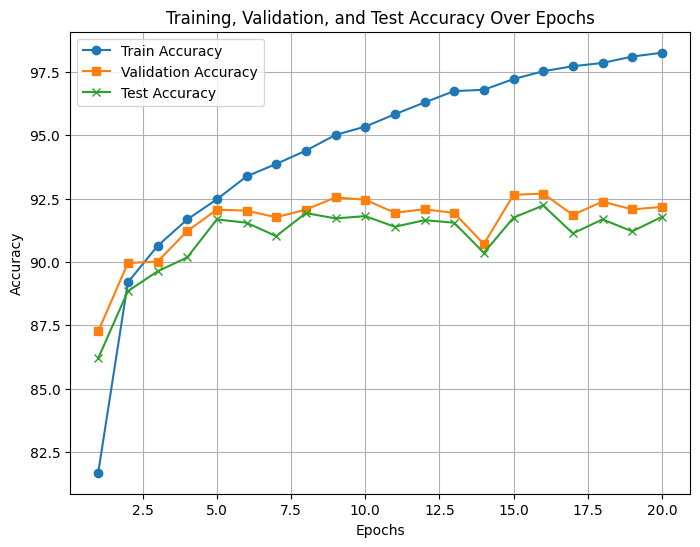

In [35]:
# Do not change this cell
plot_accuracy_performance(train_accuracies, valid_accuracies, test_accuracies)

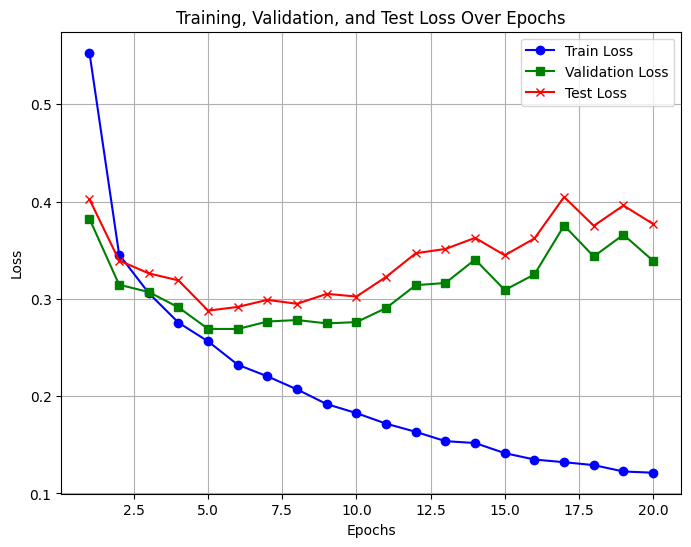

In [36]:
# Do not change this cell
plot_loss_performance(train_losses, valid_losses, test_losses)